#  DDPG Crypto-Currency Trading

In [280]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.finance as mpf
from matplotlib.pylab import date2num
from HuobiServices import *
from DataUtils import *
import talib
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
%matplotlib inline

In [281]:
lmap=lambda func,it: list(map(lambda x:func(x),it))
lfilter=lambda func,it: list(filter(lambda x:func(x),it))
z_score=lambda x:(x-np.mean(x,axis=0))/(np.std(x,axis=0)+1e-5)

In [400]:
# assets=['kan','eos','wicc']
assets=assets=['bat']
asset_data=lfilter(lambda x:x[1] is not None,lmap(lambda x:(x,kline(x,interval='15min',count=2000)),assets))
asset_data=lmap(lambda x:(x[0],generate_tech_data(x[1],close_name='close',high_name='high',low_name='low',open_name='open')),asset_data)
asset_data=dict(asset_data)
asset_data=pd.Panel(asset_data)

In [408]:
#####################  hyper parameters  ####################

LR_A = 1e-3    # learning rate for actor
LR_C = 2e-3   # learning rate for critic
GAMMA = 0.99     # reward discount
TAU = 0.05      # soft replacement
MEMORY_CAPACITY = 200
BATCH_SIZE = 128

###############################  DDPG  ####################################

class DDPG(object):
    def __init__(self, a_dim, s_dim,):
        tf.reset_default_graph()
        self.memory = np.zeros((MEMORY_CAPACITY, s_dim * 2 + a_dim + 1), dtype=np.float32)
        self.pointer = 0
        self.sess = tf.Session()

        self.a_dim, self.s_dim = a_dim, s_dim
        self.S = tf.placeholder(tf.float32, [None, s_dim], 's')
        self.S_ = tf.placeholder(tf.float32, [None, s_dim], 's_')
        self.R = tf.placeholder(tf.float32, [None, 1], 'r')

        with tf.variable_scope('Actor', initializer=tf.contrib.layers.xavier_initializer(uniform=True), regularizer=tf.contrib.layers.l2_regularizer(0.01)):
            self.a = self._build_a(self.S, scope='eval', trainable=True)
            a_ = self._build_a(self.S_, scope='target', trainable=False)
        with tf.variable_scope('Critic', initializer=tf.contrib.layers.xavier_initializer(uniform=True), regularizer=tf.contrib.layers.l2_regularizer(0.01)):
            q = self._build_c(self.S, self.a, scope='eval', trainable=True)
            q_ = self._build_c(self.S_, a_, scope='target', trainable=False)

        self.ae_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Actor/eval')
        self.at_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Actor/target')
        self.ce_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Critic/eval')
        self.ct_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Critic/target')

        self.soft_replace = [[tf.assign(ta, (1 - TAU) * ta + TAU * ea), tf.assign(tc, (1 - TAU) * tc + TAU * ec)]
                             for ta, ea, tc, ec in zip(self.at_params, self.ae_params, self.ct_params, self.ce_params)]

        q_target = self.R + GAMMA * q_
        td_error = tf.losses.mean_squared_error(labels=q_target, predictions=q)
        self.ctrain = tf.train.AdamOptimizer(LR_C).minimize(td_error, var_list=self.ce_params)

        a_loss = - tf.reduce_mean(q)    # maximize the q
        self.atrain = tf.train.AdamOptimizer(LR_A).minimize(a_loss, var_list=self.ae_params)

        self.sess.run(tf.global_variables_initializer())

    def trade(self, s, train=False):
        action=self.sess.run(self.a, {self.S: s})[0]
        action_index=np.arange(a_dim)
        if train:
            choice=np.random.choice(action_index,p=action)
            action=np.zeros(a_dim)
            action[choice]=1
            return action
        else:
            select_action=np.argmax(action)
            action=np.zeros(a_dim)
            action[select_action]=1
            return action

    def learn(self):
        self.sess.run(self.soft_replace)

        indices = np.random.choice(MEMORY_CAPACITY, size=BATCH_SIZE)
        bt = self.memory[indices, :]
        bs = bt[:, :self.s_dim]
        ba = bt[:, self.s_dim: self.s_dim + self.a_dim]
        br = bt[:, -self.s_dim - 1: -self.s_dim]
        bs_ = bt[:, -self.s_dim:]

        self.sess.run(self.atrain, {self.S: bs})
        self.sess.run(self.ctrain, {self.S: bs, self.a: ba, self.R: br, self.S_: bs_})

    def store_transition(self, s, a, r, s_):
        transition = np.hstack((s, a, [r], s_))
        index = self.pointer % MEMORY_CAPACITY  # replace the old memory with new memory
        self.memory[index, :] = transition
        self.pointer += 1
    def restore_buffer():
        self.memory=np.zeros((MEMORY_CAPACITY, self.s_dim * 2 + self.a_dim + 1), dtype=np.float32)

    def _build_a(self, s, scope, trainable):
        with tf.variable_scope(scope):
            net = tf.layers.dense(s, 128, activation=tf.nn.relu, name='l1', trainable=trainable)
            net = tf.layers.dense(net, 64, activation=tf.nn.relu, name='l2', trainable=trainable)
            a = tf.layers.dense(net, self.a_dim, activation=None, name='a', trainable=trainable)
            a=tf.nn.softmax(a)
            return a

    def _build_c(self, s, a, scope, trainable):
        with tf.variable_scope(scope):
            s=tf.layers.dense(s, 128, activation=tf.nn.relu, name='l1', trainable=trainable)
            s=tf.layers.dense(s, 64, activation=tf.nn.relu, name='l2', trainable=trainable)
            n_l1=32
            w1_s = tf.get_variable('w1_s', [64, n_l1], trainable=trainable)
            w1_a = tf.get_variable('w1_a', [self.a_dim, n_l1], trainable=trainable)
            b1 = tf.get_variable('b1', [1, n_l1], trainable=trainable)
            net = tf.nn.relu(tf.matmul(s, w1_s) + tf.matmul(a, w1_a) + b1)
            return tf.layers.dense(net, 1, trainable=trainable)

In [411]:
a_dim=asset_data.shape[0]+1
s_dim=asset_data.shape[0]*asset_data.shape[2]
ddpg = DDPG(a_dim, s_dim)

In [412]:
normalize_length=10
train_length=1500
batch_size=30
c=1e-4
epoch=30
train_r=[]
train_mean_r=[]
test_r=[]
test_mean_r=[]
for e in range(epoch):
    train_reward=[]
    test_reward=[]
    test_actions=[]
    previous_action=np.zeros(a_dim)
    for t in range(normalize_length,train_length):
        state=asset_data[:,t-normalize_length:t,:].values
        next_state=asset_data[:,t-normalize_length+1:t+1,:].values
        state=state.reshape((state.shape[1],state.shape[0]*state.shape[2]))
        next_state=next_state.reshape((next_state.shape[1],next_state.shape[0]*next_state.shape[2]))
        state=z_score(state)[None,-1]
        next_state=z_score(next_state)[None,-1]
        action=ddpg.trade(s=state,train=True)
        r=np.sum(asset_data[:,:,'diff'].iloc[t].values*action[:-1]-c*np.sum(np.abs(previous_action-action)))
        ddpg.store_transition(state[0], action, r, next_state[0])
        if ddpg.pointer > MEMORY_CAPACITY:
            if t%50==0:
                ddpg.learn()
        train_reward.append(r)
        previous_action=action
    print(e,'train_reward',np.sum(train_reward),np.mean(train_reward))
    train_r.append(np.sum(train_reward))
    train_mean_r.append(np.mean(train_reward))
    previous_action=np.zeros(a_dim)
    for t in range(train_length,asset_data.shape[1]):
        state=asset_data[:,t-normalize_length:t,:].values
        state=state.reshape((state.shape[1],state.shape[0]*state.shape[2]))
        state=z_score(state)[None,-1]
        action=ddpg.trade(s=state,train=False)
        r=np.sum(asset_data[:,:,'diff'].iloc[t].values*action[:-1]-c*np.sum(np.abs(previous_action-action)))
        test_reward.append(r)
        test_actions.append(action)
        previous_action=action
    print(e,'test_reward',np.sum(test_reward),np.mean(test_reward))
    test_r.append(np.sum(test_reward))
    test_mean_r.append(np.mean(test_reward))
    if np.sum(test_reward)>0.4:
        break

0 train_reward -0.04514045325992651 -3.0295606214715776e-05
0 test_reward -0.008199313573539257 -1.876273128956352e-05
1 train_reward 0.00217998066322158 1.4630742706185099e-06
1 test_reward 0.04246341086977627 9.717027658987705e-05
2 train_reward 0.240871262193762 0.00016165856523071276
2 test_reward 0.1269890629859816 0.0002905928214782187
3 train_reward 0.24337124405309998 0.00016333640540476508
3 test_reward 0.17628504859862734 0.00040339828054605797
4 train_reward 0.2654541335038373 0.00017815713657975656
4 test_reward 0.08119226497316269 0.00018579465668915946
5 train_reward 0.35284563224113075 0.0002368091491551213
5 test_reward 0.19306108212198017 0.0004417873732768425
6 train_reward 0.3244628196124451 0.00021776028161909068
6 test_reward 0.20940030924381572 0.00047917690902474994
7 train_reward 0.4158860014324191 0.0002791181217667242
7 test_reward 0.31001335895388643 0.0007094127207182756
8 train_reward 0.4516744717760242 0.00030313722937988204
8 test_reward 0.242284127955848

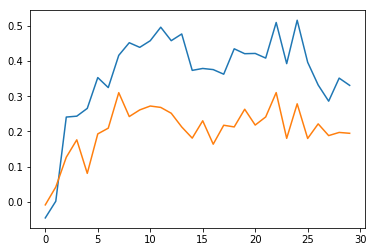

In [413]:
plt.plot(train_r)
plt.plot(test_r)

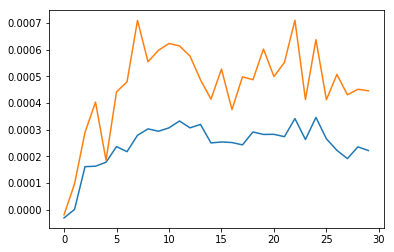

In [414]:
plt.plot(train_mean_r)
plt.plot(test_mean_r)

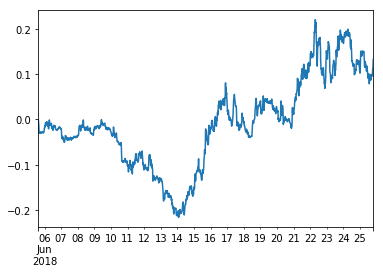

In [415]:
asset_data[:,:,'diff'].sum(axis=1).cumsum().plot()

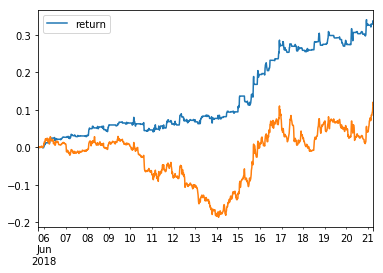

In [416]:
pd.DataFrame(train_reward,index=asset_data[:,normalize_length:train_length,'diff'].index,columns=['return']).cumsum().plot()
asset_data[:,normalize_length:train_length,'diff'].sum(axis=1).cumsum().plot()

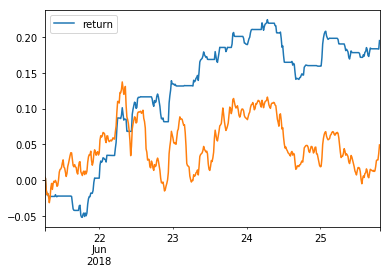

In [417]:
pd.DataFrame(test_reward,index=asset_data[:,train_length:,'diff'].index,columns=['return']).cumsum().plot()
asset_data[:,train_length:,'diff'].sum(axis=1).cumsum().plot()

In [418]:
np.sum(test_reward)

0.1948214367119423

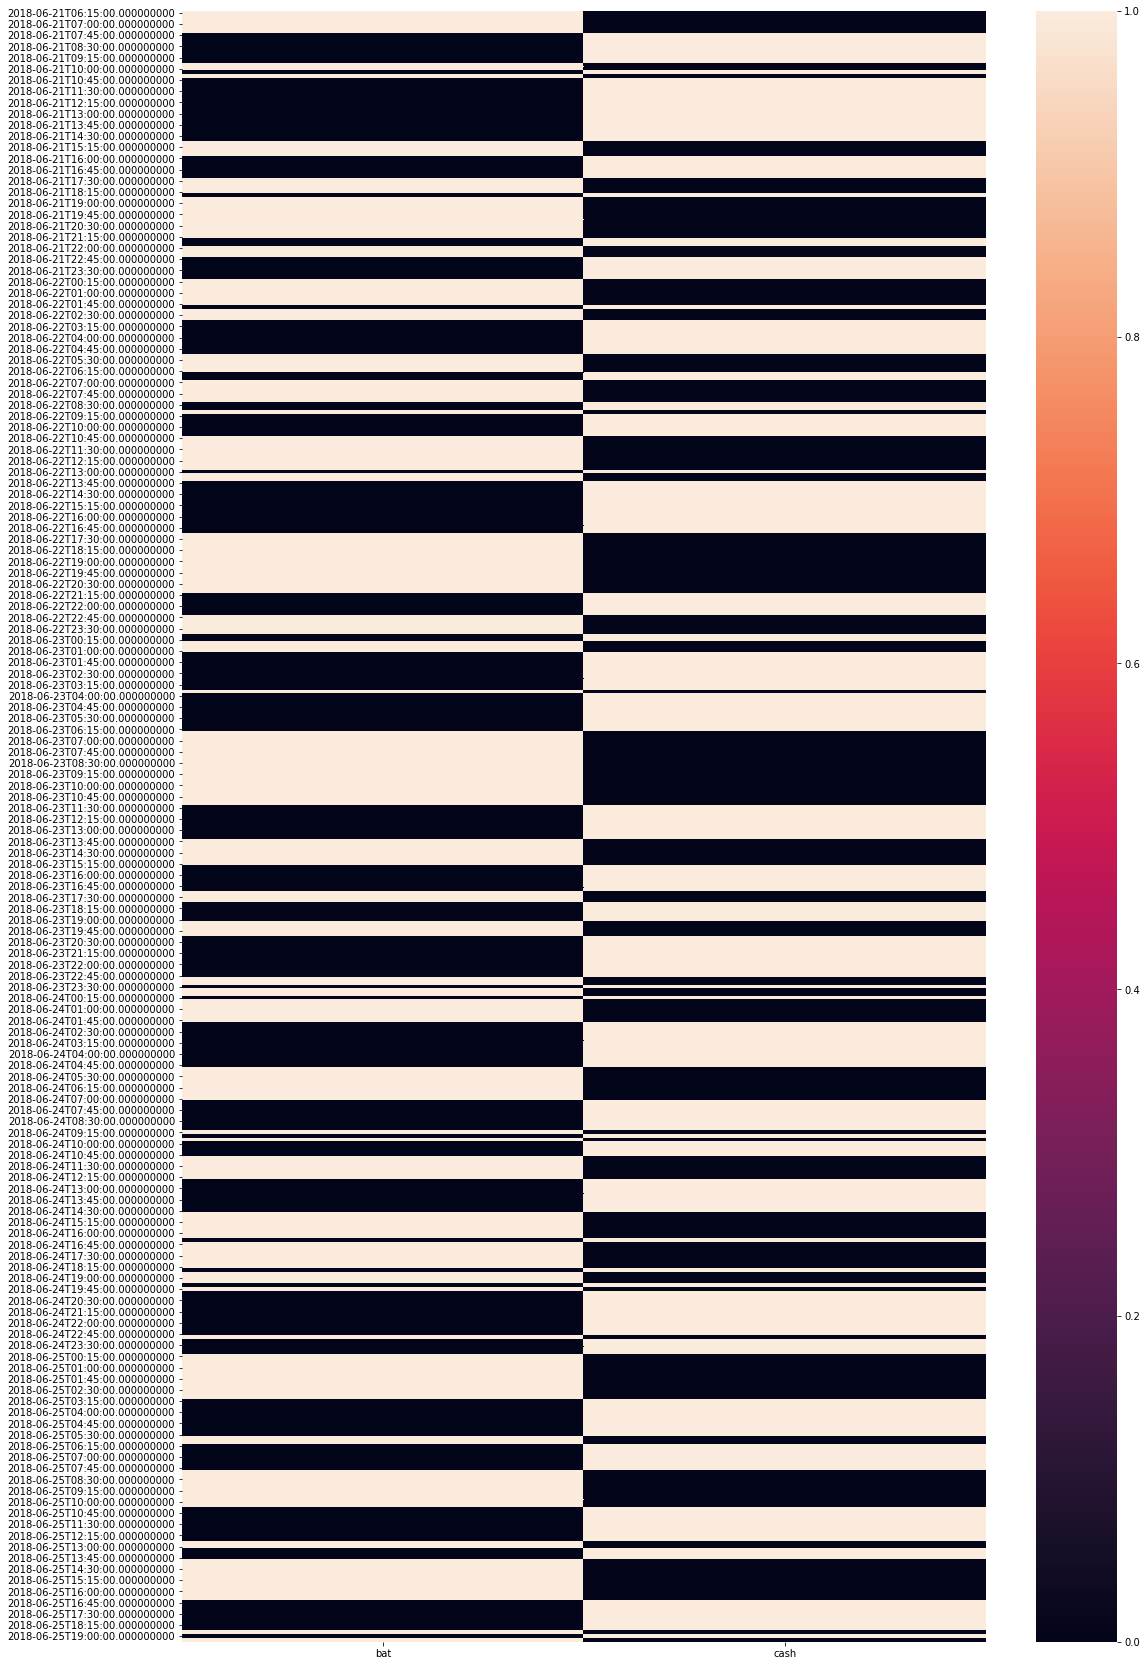

In [419]:
test_action_df=pd.DataFrame(test_actions,index=asset_data[:,train_length:,'diff'].index,columns=list(asset_data.items)+['cash'])
plt.figure(figsize=(18,30))
sns.heatmap(test_action_df)

In [420]:
np.abs(test_action_df.shift(1)-test_action_df).sum()

bat     80.0
cash    80.0
dtype: float64